Prediction of the BTC volatility using LSTM.

In [15]:
from datetime import datetime

import jax
import yfinance as yf
from flax import nnx
import jax.numpy as jnp
import pandas as pd
import tqdm


<h1> BTC Volatility Prediction using LSTM</h1>
<p> In this notebook we will predict the volatility of BTC using an ML model based on LSTM. The model will be trained using
FLAX NNX a new neural network library for JAX. FLAX NNX is also used in ie Gemma 3 or Imagen by Google</p>

In [16]:
# First we need to define some Hyperparameters so that we can change them easily
VOLATILITY_WINDOW = 30  # Window size for calculating volatility in days
TIMESERIES_LENGTH = 60  # Length of the time series to use for training
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 10  # Number of epochs to train the model

SHOW_DEBUG_INFO = True  # Whether to show debug information during training



Lets first download the data.

In [17]:
import os

def download_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Download historical data for a given ticker."""
    # check if the data is already downloaded
    if f"{ticker}_data.csv" in os.listdir():
        print(f"Data for {ticker} already downloaded.")
        dataframe = pd.read_csv(f"{ticker}_data.csv", index_col=0, parse_dates=True, date_format="%Y-%m-%d")
        # remove first two rows as they are not needed
        dataframe = dataframe.iloc[2:]
        # interpret all but the first column as float
        for col in dataframe.columns[1:]:
            dataframe[col] = pd.to_numeric(dataframe[col], errors='raise')
        dataframe['Close'] = pd.to_numeric(dataframe['Close'], errors='raise')
        return dataframe


    data = yf.download(ticker, start=start, end=end)
    # save the data to a CSV file
    data.to_csv(f"{ticker}_data.csv")

    return data


btc = download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
#btc = yf.download('BTC-USD', start='2015-01-01', end='2023-10-01')
if SHOW_DEBUG_INFO:
    print(f"Downloaded {len(btc)} rows of data for BTC-USD")
    print(f"Columns: {btc.columns.tolist()}")
    print(f"Data types:\n{btc.dtypes}")
    btc.info()

Data for BTC-USD already downloaded.
Downloaded 3195 rows of data for BTC-USD
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3195 entries, 2015-01-01 to 2023-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3195 non-null   float64
 1   High    3195 non-null   float64
 2   Low     3195 non-null   float64
 3   Open    3195 non-null   float64
 4   Volume  3195 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 149.8+ KB


In [18]:
def calculate_daily_volatility(data: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    data['Returns'] = data['Close'].pct_change()
    data['Annualized_Volatility'] = data['Returns'].rolling(window=window).std() * (252 ** 0.5)  # Annualize the volatility
    return data

btc = calculate_daily_volatility(btc)
if SHOW_DEBUG_INFO:
    print(f"Calculated daily volatility for BTC-USD with a window of {VOLATILITY_WINDOW} days")
    print(f"Data after calculating volatility:\n{btc.head()}")
    print(f"Data types after calculating volatility:\n{btc.dtypes}")

Calculated daily volatility for BTC-USD with a window of 30 days
Data after calculating volatility:
                 Close        High         Low        Open    Volume  \
Price                                                                  
2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550   
2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650   
2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400   
2015-01-04  264.195007  287.230011  257.612000  281.145996  55629100   
2015-01-05  274.473999  278.341003  265.084015  265.084015  43962800   

             Returns  Annualized_Volatility  
Price                                        
2015-01-01       NaN                    NaN  
2015-01-02  0.002492                    NaN  
2015-01-03 -0.107767                    NaN  
2015-01-04 -0.060079                    NaN  
2015-01-05  0.038907                    NaN  
Data types after calculating volatility:
Close                    float64

In [36]:
# preprocessing the data
def scale_dataframe_minus_one_to_one(df: pd.DataFrame, columns_to_scale: list[str]) -> pd.DataFrame:
    """
    Scales all numeric columns in a Pandas DataFrame to the range [-1, 1].

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new Pandas DataFrame with numeric columns scaled to [-1, 1].
        Non-numeric columns are returned unchanged.
        :param df: The Dataframe to scale.
        :param columns_to_scale: A list of column names to scale. If empty, no column will be scaled.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_scaled = df.copy()

    # Iterate over each column in the DataFrame
    for column in df_scaled.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_scaled[column]) and column in columns_to_scale:
            min_val = df_scaled[column].min()
            max_val = df_scaled[column].max()

            # Check if min_val and max_val are the same to avoid division by zero
            if min_val == max_val:
                # If all values are the same, scale them to 0
                # (or you could choose -1 or 1, but 0 is neutral)
                df_scaled[column] = 0.0
            else:
                # Apply the scaling formula: 2 * (x - min) / (max - min) - 1
                df_scaled[column] = 2 * (df_scaled[column] - min_val) / (max_val - min_val) - 1
        else:
            # If column is not numeric, print a warning and leave it as is
            print(f"Warning: Column '{column}' is not numeric or not in the list to scale and will not be scaled.")

    return df_scaled

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    # To Test the targe will be the index in of the next row
    data['Target'] = data['Annualized_Volatility'].shift(-1)  # Shift the target by one row
    # Drop the last row as it will have NaN target
    data = data.dropna()
    # Select relevant features
    features = ['Annualized_Volatility']# ['Open', 'High', 'Low', 'Close', 'Volume'] # ggf add annualized volatility

    # scale the features between -1 and 1
    data = scale_dataframe_minus_one_to_one(data, features)

    return data[features + ['Target']]


if SHOW_DEBUG_INFO:
    print("Preprocessing data...")
    print(f"Data after preprocessing:\n{preprocess_data(btc).head(100)}")

Preprocessing data...
Data after preprocessing:
            Annualized_Volatility    Target
Price                                      
2015-01-31               0.611267  1.199454
2015-02-01               0.625526  1.172109
2015-02-02               0.584628  1.166827
2015-02-03               0.576728  1.160287
2015-02-04               0.566945  1.157118
...                           ...       ...
2015-05-06              -0.595789  0.396399
2015-05-07              -0.575574  0.394430
2015-05-08              -0.578518  0.394868
2015-05-09              -0.577864  0.384202
2015-05-10              -0.593817  0.384708

[100 rows x 2 columns]


Now let's create a simple LSTM model to predict the volatility...

In [82]:
# These are all imports specific to the LSTM cell implementation
# Therefore they are not in the top of the file
from typing import Any
from collections.abc import Callable
from functools import partial

from flax.nnx import rnglib
from flax.nnx.nn import initializers
from flax.nnx.nn.linear import Linear
from flax.nnx.nn.activations import sigmoid
from flax.nnx.nn.activations import tanh
from flax.typing import (
    Dtype,
    Initializer,
    Shape, Array
)

default_kernel_init = initializers.lecun_normal()
default_bias_init = initializers.zeros_init()


def modified_orthogonal(key: Array, shape: Shape, dtype: Dtype = jnp.float32) -> Array:
    """Modified orthogonal initializer for compatibility with half precision."""
    initializer = initializers.orthogonal()
    return initializer(key, shape).astype(dtype)

class LSTMCell(nnx.RNNCellBase):
    r"""LSTM cell.

    A good part of this code is stolen from the JAX NNX library, but because I need to modify the
    activation function to depend on the input and the hidden state, I had to copy it here.
    But that should be fine as the FLAX NNX library is under the Apache 2.0 license.

    The mathematical definition of the cell is as follows

    .. math::
      \begin{array}{ll}
      i = \sigma(W_{ii} x + W_{hi} h + b_{hi}) \\
      f = \sigma(W_{if} x + W_{hf} h + b_{hf}) \\
      g = \tanh(W_{ig} x + W_{hg} h + b_{hg}) \\
      o = \sigma(W_{io} x + W_{ho} h + b_{ho}) \\
      c' = f * c + i * g \\
      h' = o * \tanh(c') \\
      \end{array}

    where x is the input, h is the output of the previous time step, and c is
    the memory.
    """

    __data__ = ('ii', 'if_', 'ig', 'io', 'hi', 'hf', 'hg', 'ho', 'rngs')

    def __init__(
        self,
        in_features: int,
        hidden_features: int,
        *,
        gate_fn: Callable[..., Any] = sigmoid,
        activation_fn: Callable[..., Any] = tanh,
        kernel_init: Initializer = default_kernel_init,
        recurrent_kernel_init: Initializer = modified_orthogonal,
        bias_init: Initializer = initializers.zeros_init(),
        dtype: Dtype | None = None,
        param_dtype: Dtype = jnp.float32,
        carry_init: Initializer = initializers.zeros_init(),
        rngs: rnglib.Rngs,
        ):
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.gate_fn = gate_fn
        self.activation_fn = activation_fn
        self.kernel_init = kernel_init
        self.recurrent_kernel_init = recurrent_kernel_init
        self.bias_init = bias_init
        self.dtype = dtype
        self.param_dtype = param_dtype
        self.carry_init = carry_init
        self.rngs = rngs

        # input and recurrent layers are summed so only one needs a bias.
        dense_i = partial(
          Linear,
          in_features=in_features,
          out_features=hidden_features,
          use_bias=False,
          kernel_init=self.kernel_init,
          dtype=self.dtype,
          param_dtype=self.param_dtype,
          rngs=rngs,
        )

        dense_h = partial(
          Linear,
          in_features=hidden_features,
          out_features=hidden_features,
          use_bias=True,
          kernel_init=self.recurrent_kernel_init,
          bias_init=self.bias_init,
          dtype=self.dtype,
          param_dtype=self.param_dtype,
          rngs=rngs,
        )

        self.garch = GARCHModel()

        self.ii = dense_i()
        self.if_ = dense_i()
        self.ig = dense_i()
     #   self.io = dense_i() this is not used due to the fact that the GARCH model is used instead of the output gate
        self.hi = dense_h()
        self.hf = dense_h()
        self.hg = dense_h()
       # self.ho = dense_h() same reason as above, the GARCH model is used instead of the output gate

        # The output gate is replaced by the GARCH model
        self.ho = Linear(
            in_features=hidden_features,
            out_features=hidden_features,
            use_bias=True,
            kernel_init=self.recurrent_kernel_init,
            bias_init=self.bias_init,
            dtype=self.dtype,
            param_dtype=self.param_dtype,
            rngs=rngs
        )

        # Initialize the carry state
        self.carry_init = initializers.zeros_init()

    def __call__(
        self, carry: tuple[Array, Array], inputs: Array
        ) -> tuple[tuple[Array, Array], Array]:  # type: ignore[override]
        r"""A long short-term memory (LSTM) cell.

        Args:
          carry: the hidden state of the LSTM cell,
            initialized using ``LSTMCell.initialize_carry``.
          inputs: an ndarray with the input for the current time step.
            All dimensions except the final are considered batch dimensions.

        Returns:
          A tuple with the new carry and the output.
        """
        c, h = carry
        i = self.gate_fn(self.ii(inputs) + self.hi(h))
        f = self.gate_fn(self.if_(inputs) + self.hf(h))
        g = self.activation_fn(self.ig(inputs) + self.hg(h))
        # Apply the GARCH model to the input and hidden state.
        o = self.garch(inputs, h)
        new_c = f * c + i * g
        new_h = o * self.activation_fn(new_c)
        return (new_c, new_h), new_h

    def initialize_carry(
        self, input_shape: tuple[int, ...], rngs: rnglib.Rngs | None = None
        ) -> tuple[Array, Array]:  # type: ignore[override]
        """Initialize the RNN cell carry.

        Args:
          rng: random number generator passed to the init_fn.
          input_shape: a tuple providing the shape of the input to the cell.
        Returns:
          An initialized carry for the given RNN cell.
        """
        batch_dims = input_shape[:-1]
        if rngs is None:
          rngs = self.rngs
        mem_shape = batch_dims + (self.hidden_features,)
        c = self.carry_init(rngs.carry(), mem_shape, self.param_dtype)
        h = self.carry_init(rngs.carry(), mem_shape, self.param_dtype)
        return c, h

    @property
    def num_feature_axes(self) -> int:
        return 1



class GARCHModel(nnx.Module):
    """This model implements a GARCH(1, 1) model layer for volatility prediction.
    The idea is that as indicated in the paper "From GARCH to Neural Network for Volatility Forecast" we can enhance
    the LSTM model with a GARCH layer to improve the volatility prediction. """
    def __init__(self):
        initial_param_value = jnp.zeros((1, 1)) + 0.1  # Initialize parameters to zero
        self.alpha_raw = nnx.Param(initial_param_value)
        self.beta_raw = nnx.Param(initial_param_value)
        self.omega_raw = nnx.Param( initial_param_value)

    def __call__(self, x: jnp.ndarray, h:jnp.ndarray) -> jnp.ndarray:
        """Forward pass of the GARCH model. x is the input data at time t and h is the hidden state.
        So h could be seen as the previous volatility prediction."""
        # Calculate the GARCH(1, 1) volatility
        # x does not need to be squared as it is already defined as such
        # for now we assume that x is of shape (batch_size, 1)
        assert x.shape == (x.shape[0], 1), "Input x must be of shape (batch_size, 1)"
        h_squared = jnp.square(h)
        omega = self.omega_raw.value
        alpha = self.alpha_raw.value
        beta =  self.beta_raw.value
        return omega + alpha * x + beta * h_squared




if SHOW_DEBUG_INFO:
    model = GARCHModel()
    nnx.display(model)


In [79]:
# now lets define the LSTM model

class LSTM(nnx.Module):

    def __init__(self, features: int, hidden_features: int = 256, rngs: nnx.Rngs | None = None):
        """Initialize the LSTM model."""
        self.cell = LSTMCell(
            features,
            hidden_features,
            rngs=rngs
        )
        self.hidden_size = hidden_features
        self.features = features
        self.recurrent_layer = nnx.RNN(
            cell=self.cell,
            rngs=rngs
        )

        self.linear_layer = nnx.Linear(
            in_features=hidden_features,
            out_features=1,  # Output a single value for volatility prediction
            use_bias=True,
            rngs=rngs
        )

    def __call__(self, x):
        """Forward pass of the LSTM"""
        y = self.recurrent_layer(x)
        last_cell_output = y[:, -1, :]
        final_y = self.linear_layer(last_cell_output)
        return final_y

if SHOW_DEBUG_INFO:
    lstm = LSTM(4, 256, nnx.Rngs(jax.random.PRNGKey(0)))
    nnx.display(lstm)


In [83]:
import optax


# Alright, now lets define some helper functions
def compute_metrics(predictions: jnp.ndarray, targets: jnp.ndarray) -> dict:
    """Compute metrics for the model predictions."""
    mse = jnp.mean((predictions - targets) ** 2)
    mae = jnp.mean(jnp.abs(predictions - targets))
    return {'mse': mse, 'mae': mae}

def create_training_state(rng: nnx.Rngs) -> tuple[nnx.Module, optax.GradientTransformation]:
    """Create a training state for the model."""
    lstm = LSTM(features=6, rngs=rng)
    tx = optax.adam(1e-3)
    return lstm, tx

def loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

@nnx.jit
def train_step(model, optimizer, x, y):
  grad_fn = nnx.value_and_grad(loss_fn)
  loss, grads = grad_fn(model, x, y)
  optimizer.update(grads)  # In place updates.
  return loss

def transform_data_to_training_timeseries(data: pd.DataFrame, window_size: int = 100) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Transform the DataFrame into a time series format for training."""
    # Convert DataFrame to JAX array
    y = jnp.array(data['Target'])
    x_unformatted = jnp.array(data.drop(columns=['Target']))
    x = jnp.array([x_unformatted[i:i + window_size] for i in range(len(x_unformatted) - window_size)])
    y = y[window_size:] # drop label for series that are not complete
    return x, y

def train_test_split(data: pd.DataFrame, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into training and testing sets."""
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data


In [86]:
# Now we can run the training loop
from sklearn.utils import shuffle

def train_model(model, optimizer, X_train: jnp.ndarray, Y_train: jnp.ndarray, epochs: int = 10, batch_size: int = 32):
    """Train the LSTM model."""
    for epoch in range(epochs):
        for i in tqdm.tqdm(range(0, len(X_train), batch_size)):
            x_batch: jnp.array = X_train[i:i + batch_size]
            y_batch: jnp.array = Y_train[i:i + batch_size]
            loss = train_step(model, optimizer, x_batch, y_batch)
        print(f"Epoch {epoch + 1}, Loss: {loss:.8f}")



lstm = LSTM(features=1,hidden_features=256, rngs=nnx.Rngs(jax.random.PRNGKey(0)))
optimizer = nnx.Optimizer(lstm, optax.adam(1e-3))  # Using Adam optimizer
pre_data = preprocess_data(btc)
# Split the data into training and testing sets
train_data, test_data = train_test_split(pre_data, test_size=0.2)
X_train, y_train = transform_data_to_training_timeseries(train_data, window_size=TIMESERIES_LENGTH)
# shuffle the timeseries data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)

train_model(lstm, optimizer, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

100%|██████████| 78/78 [00:02<00:00, 26.68it/s]


Epoch 1, Loss: 0.00735125


100%|██████████| 78/78 [00:02<00:00, 35.21it/s] 


Epoch 2, Loss: 0.00336952


100%|██████████| 78/78 [00:02<00:00, 36.73it/s] 


Epoch 3, Loss: 0.00612018


100%|██████████| 78/78 [00:02<00:00, 36.28it/s] 


Epoch 4, Loss: 0.00639916


100%|██████████| 78/78 [00:02<00:00, 36.88it/s] 


Epoch 5, Loss: 0.00484645


100%|██████████| 78/78 [00:02<00:00, 35.52it/s] 


Epoch 6, Loss: 0.00464557


100%|██████████| 78/78 [00:02<00:00, 35.71it/s] 


Epoch 7, Loss: 0.00453847


100%|██████████| 78/78 [00:02<00:00, 36.21it/s] 


Epoch 8, Loss: 0.00446837


100%|██████████| 78/78 [00:02<00:00, 35.08it/s] 


Epoch 9, Loss: 0.00442494


100%|██████████| 78/78 [00:02<00:00, 36.13it/s] 


Epoch 10, Loss: 0.00437664


Test data shape: (573, 60, 1), Target shape: (573,)
{'mse': Array(0.04225114, dtype=float32), 'mae': Array(0.1678058, dtype=float32)}


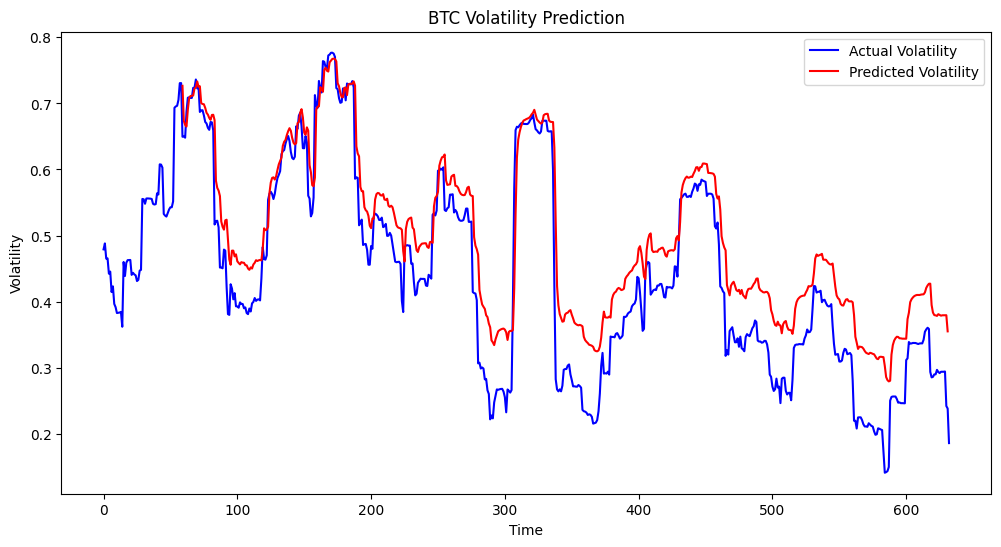

In [85]:
# Now we can evaluate the model on the test set
def evaluate_model(model: LSTM, data: pd.DataFrame):
    """Evaluate the model on the test set."""
    # First, transform the test data into the same format as the training data
    x, y = transform_data_to_training_timeseries(data, window_size=TIMESERIES_LENGTH)
    print(f"Test data shape: {x.shape}, Target shape: {y.shape}")
    prediction = model(x)
    metrics = compute_metrics(prediction, y)

    # add TIMESERIES_LENGTH - 1 to the start of the prediction to align it with the target
    prediction = jnp.concatenate([jnp.full((TIMESERIES_LENGTH -1, 1), jnp.nan), prediction], axis=0)
    return metrics, prediction

# plot the predictions against the actual values
import matplotlib.pyplot as plt
def plot_predictions(predictions: jnp.ndarray, targets: jnp.ndarray):
    """Plot the predictions against the actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual Volatility', color='blue')
    plt.plot(predictions, label='Predicted Volatility', color='red')
    plt.title('BTC Volatility Prediction')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


# Evaluate the model on the test set
metrics, predictions = evaluate_model(lstm, test_data)
# get the last element of every series in predictions
  # Get the last element of each series
print(metrics)
plot_predictions(predictions, test_data['Target'].to_numpy())